In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Function to create the dataset using tf.data pipeline
def create_dataset(folder, batch_size, img_size):
    pattern = os.path.join(folder, '*/*.jpg')  # Correct file pattern
    dataset = tf.data.Dataset.list_files(pattern)

    def process_image(file_path):
        label = tf.strings.split(file_path, os.path.sep)[-2]
        label = tf.argmax(label == classes)
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = img / 255.0
        return img, label

    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Allow for data pipelining
    return dataset

# Define data paths and parameters
data_path = "/Users/raghavgarg/Downloads/archive"
train_data_path = os.path.join(data_path, 'seg_train/seg_train')
test_data_path = os.path.join(data_path, 'seg_test/seg_test')
img_size = (128, 128)
batch_size = 32
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Create training and testing datasets
train_dataset = create_dataset(train_data_path, batch_size, img_size)
test_dataset = create_dataset(test_data_path, batch_size, img_size)

# Define a strategy to distribute computation across available GPUs
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Base model (DenseNet169) with pre-trained ImageNet weights
    base_model = tf.keras.applications.DenseNet169(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers on top of the base model
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    preds = layers.Dense(len(classes), activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=preds)

    # Compile the model with a learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Training the model with callbacks for better performance
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(train_dataset, epochs=80, validation_data=test_dataset, callbacks=callbacks)

# Evaluate the model
model.evaluate(test_dataset)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/80


2024-08-24 15:30:14.330279: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6071 - loss: 1.1041

2024-08-24 15:34:26.030005: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6074 - loss: 1.1032

2024-08-24 15:34:26.586473: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-24 15:35:30.771091: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 318s 714ms/step - accuracy: 0.6078 - loss: 1.1023 - val_accuracy: 0.8837 - val_loss: 0.3337
Epoch 2/80


2024-08-24 15:35:32.353031: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.8628 - loss: 0.3777

2024-08-24 15:40:39.085612: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-24 15:41:46.882173: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 376s 857ms/step - accuracy: 0.8628 - loss: 0.3777 - val_accuracy: 0.8947 - val_loss: 0.2915
Epoch 3/80


2024-08-24 15:41:48.447815: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.8860 - loss: 0.3193

2024-08-24 15:47:14.943623: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 399s 909ms/step - accuracy: 0.8860 - loss: 0.3193 - val_accuracy: 0.9043 - val_loss: 0.2705
Epoch 4/80


2024-08-24 15:48:27.414055: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9007 - loss: 0.2831

2024-08-24 15:53:59.831761: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-24 15:55:08.490895: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 403s 918ms/step - accuracy: 0.9006 - loss: 0.2831 - val_accuracy: 0.9037 - val_loss: 0.2642
Epoch 5/80


2024-08-24 15:55:10.099622: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.9015 - loss: 0.2644

2024-08-24 16:01:38.813868: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 463s 1s/step - accuracy: 0.9015 - loss: 0.2644 - val_accuracy: 0.9067 - val_loss: 0.2556
Epoch 6/80


2024-08-24 16:02:53.305470: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9126 - loss: 0.2451

2024-08-24 16:09:07.482132: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.9126 - loss: 0.2451 - val_accuracy: 0.9057 - val_loss: 0.2516
Epoch 7/80


2024-08-24 16:10:28.926643: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9167 - loss: 0.2298

2024-08-24 16:15:45.443072: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 381s 867ms/step - accuracy: 0.9167 - loss: 0.2298 - val_accuracy: 0.9087 - val_loss: 0.2440
Epoch 8/80


2024-08-24 16:16:49.620978: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9196 - loss: 0.2192

2024-08-24 16:21:25.567767: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-24 16:22:27.051556: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 338s 770ms/step - accuracy: 0.9196 - loss: 0.2192 - val_accuracy: 0.9090 - val_loss: 0.2479
Epoch 9/80


2024-08-24 16:22:27.668251: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9233 - loss: 0.2107

2024-08-24 16:26:56.637955: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 336s 765ms/step - accuracy: 0.9233 - loss: 0.2107 - val_accuracy: 0.9110 - val_loss: 0.2385
Epoch 10/80


2024-08-24 16:28:03.237955: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9362 - loss: 0.1763

2024-08-24 16:32:32.756017: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 326s 744ms/step - accuracy: 0.9362 - loss: 0.1763 - val_accuracy: 0.9090 - val_loss: 0.2382
Epoch 11/80


2024-08-24 16:33:29.589031: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9358 - loss: 0.1799

2024-08-24 16:37:49.492362: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 330s 751ms/step - accuracy: 0.9358 - loss: 0.1800 - val_accuracy: 0.9117 - val_loss: 0.2371
Epoch 12/80


2024-08-24 16:38:59.139522: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9344 - loss: 0.1745

2024-08-24 16:45:15.081964: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.9344 - loss: 0.1745 - val_accuracy: 0.9093 - val_loss: 0.2396
Epoch 13/80


2024-08-24 16:46:52.984746: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9391 - loss: 0.1640

2024-08-24 16:54:53.957850: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - accuracy: 0.9391 - loss: 0.1640 - val_accuracy: 0.9120 - val_loss: 0.2333
Epoch 14/80


2024-08-24 16:56:06.058514: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9438 - loss: 0.1602

2024-08-24 17:00:43.004528: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 329s 749ms/step - accuracy: 0.9438 - loss: 0.1602 - val_accuracy: 0.9113 - val_loss: 0.2369
Epoch 15/80


2024-08-24 17:01:34.615846: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9447 - loss: 0.1583

2024-08-24 17:05:37.822722: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 285s 648ms/step - accuracy: 0.9447 - loss: 0.1583 - val_accuracy: 0.9113 - val_loss: 0.2347
Epoch 16/80


2024-08-24 17:06:19.157060: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9481 - loss: 0.1492

2024-08-24 17:09:38.477618: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-24 17:10:24.684257: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


439/439 ━━━━━━━━━━━━━━━━━━━━ 246s 560ms/step - accuracy: 0.9481 - loss: 0.1492 - val_accuracy: 0.9117 - val_loss: 0.2384
Epoch 17/80


2024-08-24 17:10:25.131900: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9502 - loss: 0.1366

2024-08-24 17:14:03.324255: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 273s 622ms/step - accuracy: 0.9502 - loss: 0.1366 - val_accuracy: 0.9163 - val_loss: 0.2305
Epoch 18/80


2024-08-24 17:14:58.092975: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9557 - loss: 0.1338

2024-08-24 17:18:37.340921: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 268s 612ms/step - accuracy: 0.9556 - loss: 0.1338 - val_accuracy: 0.9130 - val_loss: 0.2325
Epoch 19/80


2024-08-24 17:19:26.574648: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9569 - loss: 0.1212

2024-08-24 17:23:10.990266: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 272s 620ms/step - accuracy: 0.9568 - loss: 0.1212 - val_accuracy: 0.9093 - val_loss: 0.2380
Epoch 20/80


2024-08-24 17:23:58.942023: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9556 - loss: 0.1235

2024-08-24 17:27:47.678659: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 276s 628ms/step - accuracy: 0.9556 - loss: 0.1235 - val_accuracy: 0.9123 - val_loss: 0.2356
Epoch 21/80


2024-08-24 17:28:34.678961: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9613 - loss: 0.1106

2024-08-24 17:32:22.078449: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 278s 633ms/step - accuracy: 0.9613 - loss: 0.1106 - val_accuracy: 0.9113 - val_loss: 0.2435
Epoch 22/80


2024-08-24 17:33:12.665511: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9620 - loss: 0.1104

2024-08-24 17:37:10.776925: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



439/439 ━━━━━━━━━━━━━━━━━━━━ 289s 658ms/step - accuracy: 0.9620 - loss: 0.1104 - val_accuracy: 0.9120 - val_loss: 0.2389


2024-08-24 17:38:01.484346: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 508ms/step - accuracy: 0.9136 - loss: 0.2381


[0.23049932718276978, 0.9163333177566528]

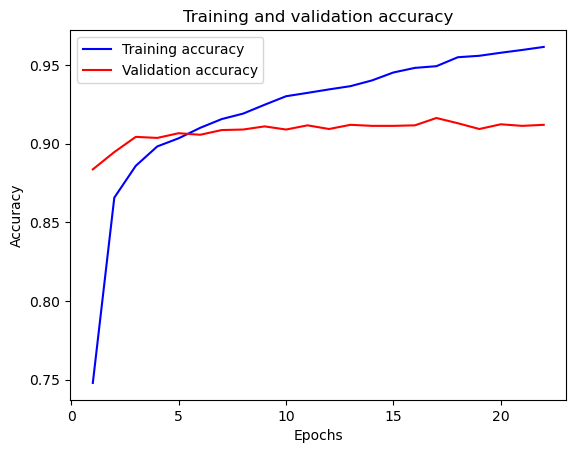

In [27]:
# Get the accuracy and validation accuracy from the history
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

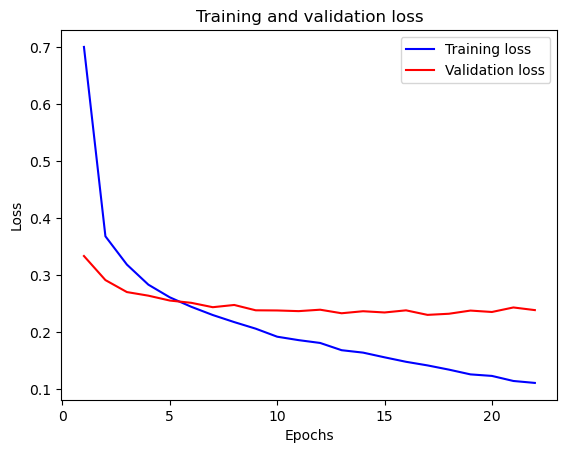

In [28]:

import matplotlib.pyplot as plt# Get the accuracy and validation loss from the history
acc = history.history['loss']
val_acc = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot training and validation loss
plt.plot(epochs, acc, 'b', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()